In [1]:
import math
import numpy as np
import itertools
import gsd.hoomd
import hoomd


In [2]:
# Setting up simulation parameters
dt=0.0001  #sim timestep
tau = dt*1000 #time constant related to thermostat (https://en.wikipedia.org/wiki/Berendsen_thermostat)
kT = 1.5 # simulation T

In [3]:
gsd_file_name = "trajectory.gsd"
gsd_write_freq = 10

In [4]:
def lj_system(n, spacing, box_factor=3):
    """
    Initating a system with one type of particle (A)
    """
    N_particles = n
    spacing = spacing
    K = math.ceil(N_particles**(1 / 3))
    L = K * spacing
    x = np.linspace(-L / 2, L / 2, K, endpoint=False)
    position = list(itertools.product(x, repeat=3))

    snapshot = gsd.hoomd.Snapshot()
    snapshot.particles.N = N_particles
    snapshot.particles.position = position[0:N_particles]
    snapshot.particles.typeid = [0] * N_particles
    snapshot.configuration.box = [L*box_factor, L*box_factor, L*box_factor, 0, 0, 0]
    snapshot.particles.types = ['A']
    return snapshot


def pair_force(sigma=1, epsilon=1):
    """
    Creates non-bonded forces between A particles.
    """
    cell = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=cell)
    lj.params[('A', 'A')] = dict(epsilon=epsilon, sigma=sigma)
    lj.r_cut[('A', 'A')] = 2.5 * sigma
    return lj

In [5]:
init_snap = lj_system(n=2, spacing=0.4, box_factor=10)

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)


In [6]:
# setting up the simulation
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device)
sim.create_state_from_snapshot(init_snap)
integrator = hoomd.md.Integrator(dt=dt)
lj = pair_force()
integrator.forces.append(lj)

In [7]:
cap = hoomd.md.methods.DisplacementCapped(filter=hoomd.filter.All(), maximum_displacement=1e-5)
# nve = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=kT, tau=tau)
integrator.methods.append(cap)
# integrator.methods.append(nve)
sim.operations.integrator = integrator

/home/marjanalbooyeh/mambaforge/envs/LJ-ML/lib/python3.11/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [8]:
sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kT)

*Warning*: Simulation.seed is not set, using default seed=0


In [9]:
snap = sim.state.get_snapshot()
snap.particles.velocity

array([[ 0.20817407,  0.58389178, -0.49044151],
       [-0.20817407, -0.58389178,  0.49044151]])

In [10]:
# Logging 
log_quantities = [
            "kinetic_temperature",
            "potential_energy",
            "kinetic_energy",
            "volume",
            "pressure",
            "pressure_tensor",
        ]
logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
logger.add(sim, quantities=["timestep", "tps"])
thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermo_props)
logger.add(thermo_props, quantities=log_quantities)

for f in integrator.forces:
    
    logger.add(f, quantities=["energy", "forces"])

gsd_writer = hoomd.write.GSD(
    filename=gsd_file_name,
    trigger=hoomd.trigger.Periodic(int(gsd_write_freq)),
    mode="wb",
    logger=logger,
    dynamic=["momentum"]
    )

sim.operations.writers.append(gsd_writer)


In [12]:
sim.run(1e3, write_at_start=True)

### Check Data from Logs

In [13]:
traj = gsd.hoomd.open("trajectory.gsd")

In [14]:
traj[0].log.keys()

dict_keys(['Simulation/timestep', 'Simulation/tps', 'md/compute/ThermodynamicQuantities/kinetic_temperature', 'md/compute/ThermodynamicQuantities/potential_energy', 'md/compute/ThermodynamicQuantities/kinetic_energy', 'md/compute/ThermodynamicQuantities/volume', 'md/compute/ThermodynamicQuantities/pressure', 'md/pair/LJ/energy', 'particles/md/pair/LJ/forces'])

In [15]:
positions = []
r = []
energies = []
forces= []

for frame in traj:
    pos = frame.particles.position
    positions.append(pos)
    r.append(np.linalg.norm(pos[0] - pos[1]))
    energies.append(frame.log['md/pair/LJ/energy'])
    forces.append(frame.log['particles/md/pair/LJ/forces'])

In [16]:
r = np.asarray(r)
energies = np.asarray(energies)
forces = np.asarray(forces)

In [17]:
np.save("r.npy", np.asarray(r))
np.save("energies.npy", np.asarray(energies))
np.save("forces.npy", np.asarray(forces))

In [19]:
r.shape

(10078,)

In [18]:
np.where(r < 0.8)[0].shape[0] / r.shape[0]

0.19845207382417146

In [20]:
min(r)

0.4

In [21]:
max(r)

1.1423466

In [22]:
min(energies)

array([-1.])

In [23]:
max(energies)

array([237441.97405631])

In [24]:
import matplotlib.pyplot as plt

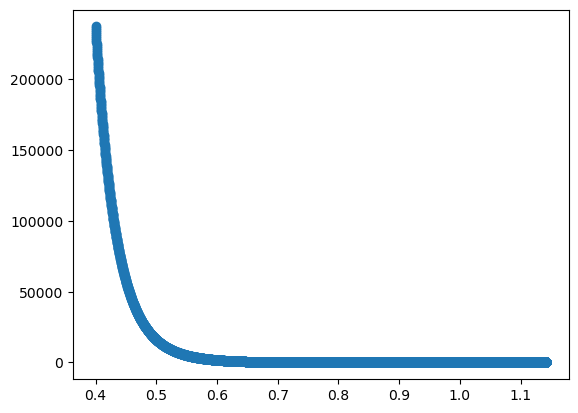

In [29]:
plt.scatter(r, energies)